# Who's the Most Consistent Player in the NBA?

Sports fans and commentators prize "consistency." There's an obvious intuitive appeal to the concept: we want to know that players are not just usually good but can be relied upon to be good every night. That said, "consistency" is usually defined in a vague or subjective manner within a sports context. For example, one of the recurring themes of the famously snarky 2000s sports blog "Fire Joe Morgan" was the (ironically) inconsistent way that sports commentators tended to use the term. 

So how can we define "consistency" in a consistent, robust way? Several popular pieces have tried to formalize this concept (e.g., https://www.theringer.com/nba/2020/1/6/21050900/most-least-consistent-nba-player), but I have found these efforts unsatisfactory. In this notebook, I'll try to do build a better consistency metric via the statistical concepts of <i>standard deviation</i> and <i>entropy</i>.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy

import calculate
import scrape

## Gathering the Data

For the purpose of this analysis, we're going to acquire all player-level game logs from basketball-reference.com. This is a comprehensive website that is relatively easy to scrape. The site keeps an index of all player pages, organized alphabetically, on URLs that are formatted 'https://www.basketball-reference.com/players/{letter}/'. We can acquire all player homepage URLs from those pages, as well as the years in which the players were active. Once we have that information, we can rely on the fact that all player game-logs URLs are formatted 'https://www.basketball-reference.com/players/{letter}/{player}/gamelog/{year}' to systematically query every year's games for every player in the league's history. Once we've done that, it is relatively simple to use the BeautifulSoup library to locate the table of statistics, find all column names, and store each game's values in a dictionary.

The basketball-reference.com website is, fortunately, friendly to these kinds of exercises and does not work very hard to rate-limit requests. So long as we include a small amount of error-handling logic in our scraping script to handle occasional timeouts and a simple retry step, we can be confident that we are getting a comprehsive account of all player gamelogs. To accelerate the process, I have multi-threaded the requests, which reduces the time to scrape the player pages from around a fully day down to a few hours.

In [2]:
all_players = scrape.get_all_player_records()

Fetching the player indices at 2022-04-18 09:11:01.774108
Loaded index from pickle
Fetching Alaa Abdelnaby at 2022-04-18 09:11:01.781091
Fetching Zaid Abdul-Aziz at 2022-04-18 09:11:05.906724
Fetching Kareem Abdul-Jabbar at 2022-04-18 09:11:11.458134
Fetching Mahmoud Abdul-Rauf at 2022-04-18 09:11:23.645178
Fetching Tariq Abdul-Wahad at 2022-04-18 09:11:30.740171
Fetching Shareef Abdur-Rahim at 2022-04-18 09:11:35.307256
Fetching Tom Abernethy at 2022-04-18 09:11:43.286412
Fetching Forest Able at 2022-04-18 09:11:47.064737
Fetching John Abramovic at 2022-04-18 09:11:49.039587
Fetching Álex Abrines at 2022-04-18 09:11:52.125553
Fetching Precious Achiuwa at 2022-04-18 09:11:55.892766
Fetching Alex Acker at 2022-04-18 09:11:59.096876
Fetching Don Ackerman at 2022-04-18 09:12:01.878913
Fetching Mark Acres at 2022-04-18 09:12:05.076199
Fetching Bud Acton at 2022-04-18 09:12:09.306004
Fetching Quincy Acy at 2022-04-18 09:12:11.492206
Fetching Alvan Adams at 2022-04-18 09:12:17.820579
Fetchin

Fetching Don Asmonga at 2022-04-18 20:32:14.710716
Fetching Dick Atha at 2022-04-18 20:32:16.753853
Fetching Chucky Atkins at 2022-04-18 20:32:20.038436
Fetching Al Attles at 2022-04-18 20:32:27.460113
Fetching Chet Aubuchon at 2022-04-18 20:32:33.415171
Fetching Stacey Augmon at 2022-04-18 20:32:35.604156
Fetching D.J. Augustin at 2022-04-18 20:32:47.068949
Fetching James Augustine at 2022-04-18 20:32:56.814199
Fetching Isaac Austin at 2022-04-18 20:32:59.444242
Fetching Johnny Austin at 2022-04-18 20:33:05.112286
Fetching Ken Austin at 2022-04-18 20:33:08.063471
Fetching Deni Avdija at 2022-04-18 20:33:10.122836
Fetching Anthony Avent at 2022-04-18 20:33:13.618144
Fetching Bird Averitt at 2022-04-18 20:33:18.273932
Fetching William Avery at 2022-04-18 20:33:21.468183
Fetching Dennis Awtrey at 2022-04-18 20:33:24.766404
Fetching Joel Ayayi at 2022-04-18 20:33:31.246006
Fetching Gustavo Ayón at 2022-04-18 20:33:33.084639
Fetching Jeff Ayres at 2022-04-18 20:33:36.334789
Fetching Deandr

Fetching Irv Bemoras at 2022-04-18 20:49:40.176045
Fetching Leon Benbow at 2022-04-18 20:49:43.145817
Fetching Dragan Bender at 2022-04-18 20:49:46.076215
Fetching Jonathan Bender at 2022-04-18 20:49:49.962861
Fetching Jerrelle Benimon at 2022-04-18 20:49:55.741537
Fetching Benoit Benjamin at 2022-04-18 20:49:57.800025
Fetching Corey Benjamin at 2022-04-18 20:50:06.664562
Fetching Anthony Bennett at 2022-04-18 20:50:10.276704
Fetching Elmer Bennett at 2022-04-18 20:50:13.610888
Fetching Mario Bennett at 2022-04-18 20:50:15.929065
Fetching Mel Bennett at 2022-04-18 20:50:19.023632
Fetching Spider Bennett at 2022-04-18 20:50:23.635301
Fetching Tony Bennett at 2022-04-18 20:50:25.587540
Fetching Winston Bennett at 2022-04-18 20:50:30.100257
Fetching David Benoit at 2022-04-18 20:50:33.412237
Fetching Keith Benson at 2022-04-18 20:50:39.539306
Fetching Kent Benson at 2022-04-18 20:50:41.598602
Fetching Ben Bentil at 2022-04-18 20:50:49.007529
Fetching Gene Berce at 2022-04-18 20:50:51.0605

Fetching Avery Bradley at 2022-04-18 21:06:16.169351
Fetching Bill Bradley at 2022-04-18 21:06:23.875250
Fetching Bill Bradley at 2022-04-18 21:06:25.705610
Fetching Charles Bradley at 2022-04-18 21:06:32.099312
Fetching Dudley Bradley at 2022-04-18 21:06:35.155516
Fetching Jim Bradley at 2022-04-18 21:06:41.416175
Fetching Joe Bradley at 2022-04-18 21:06:44.381139
Fetching Michael Bradley at 2022-04-18 21:06:46.738906
Fetching Shawn Bradley at 2022-04-18 21:06:50.507224
Fetching Tony Bradley at 2022-04-18 21:06:58.885585
Fetching Mark Bradtke at 2022-04-18 21:07:02.657626
Fetching Marques Bragg at 2022-04-18 21:07:05.346740
Fetching Torraye Braggs at 2022-04-18 21:07:08.276132
Fetching A.J. Bramlett at 2022-04-18 21:07:10.473290
Fetching Adrian Branch at 2022-04-18 21:07:12.471100
Fetching Elton Brand at 2022-04-18 21:07:15.856928
Fetching Terrell Brandon at 2022-04-18 21:07:25.864829
Fetching Bob Brannum at 2022-04-18 21:07:33.862152
Fetching Brad Branson at 2022-04-18 21:07:37.97196

Fetching Evers Burns at 2022-04-18 21:22:56.120158
Fetching Jim Burns at 2022-04-18 21:22:58.504114
Fetching Scott Burrell at 2022-04-18 21:23:00.348285
Fetching Art Burris at 2022-04-18 21:23:06.534221
Fetching Junior Burrough at 2022-04-18 21:23:09.910160
Fetching Bob Burrow at 2022-04-18 21:23:12.940751
Fetching Deonte Burton at 2022-04-18 21:23:15.573581
Fetching Ed Burton at 2022-04-18 21:23:18.403036
Fetching Willie Burton at 2022-04-18 21:23:20.499958
Fetching Steve Burtt at 2022-04-18 21:23:24.906686
Fetching Don Buse at 2022-04-18 21:23:29.662161
Fetching David Bustion at 2022-04-18 21:23:36.924782
Fetching Donnie Butcher at 2022-04-18 21:23:38.661720
Fetching Al Butler at 2022-04-18 21:23:42.084753
Fetching Caron Butler at 2022-04-18 21:23:45.049213
Fetching Greg Butler at 2022-04-18 21:23:54.061300
Fetching Jackie Butler at 2022-04-18 21:23:56.794251
Fetching Jared Butler at 2022-04-18 21:23:59.953510
Fetching Jimmy Butler at 2022-04-18 21:24:02.453215
Fetching Mike Butler a

Fetching Dionte Christmas at 2022-04-18 21:40:41.798870
Fetching Rakeem Christmas at 2022-04-18 21:40:44.290221
Fetching Semaj Christon at 2022-04-18 21:40:46.915610
Fetching Josh Christopher at 2022-04-18 21:40:50.167205
Fetching Patrick Christopher at 2022-04-18 21:40:53.230398
Fetching Stephen Chubin at 2022-04-18 21:40:55.168980
Fetching Robert Churchwell at 2022-04-18 21:40:57.130136
Fetching Archie Clark at 2022-04-18 21:40:59.083194
Fetching Carlos Clark at 2022-04-18 21:41:05.018524
Fetching Earl Clark at 2022-04-18 21:41:09.284409
Fetching Gary Clark at 2022-04-18 21:41:13.707285
Fetching Ian Clark at 2022-04-18 21:41:17.544515
Fetching Keon Clark at 2022-04-18 21:41:21.832954
Fetching Richard Clark at 2022-04-18 21:41:27.009741
Fetching Brandon Clarke at 2022-04-18 21:41:28.853932
Fetching Coty Clarke at 2022-04-18 21:41:32.243912
Fetching Jordan Clarkson at 2022-04-18 21:41:34.181372
Fetching Gian Clavell at 2022-04-18 21:41:41.112929
Fetching Victor Claver at 2022-04-18 21:

Fetching Jae Crowder at 2022-04-18 21:50:36.108558
Fetching Al Cueto at 2022-04-18 21:50:43.156126
Fetching Jarrett Culver at 2022-04-18 21:50:45.000083
Fetching Jarron Cumberland at 2022-04-18 21:50:48.277059
Fetching Pat Cummings at 2022-04-18 21:50:49.995755
Fetching Terry Cummings at 2022-04-18 21:50:56.929444
Fetching Vonteego Cummings at 2022-04-18 21:51:07.611322
Fetching Billy Cunningham at 2022-04-18 21:51:11.237178
Fetching Cade Cunningham at 2022-04-18 21:51:17.602194
Fetching Dante Cunningham at 2022-04-18 21:51:20.647352
Fetching Dick Cunningham at 2022-04-18 21:51:29.021015
Fetching Jared Cunningham at 2022-04-18 21:51:32.890086
Fetching William Cunningham at 2022-04-18 21:51:35.961512
Fetching Radisav Ćurčić at 2022-04-18 21:51:38.249168
Fetching Armand Cure at 2022-04-18 21:51:40.438552
Fetching Earl Cureton at 2022-04-18 21:51:42.392215
Fetching Bill Curley at 2022-04-18 21:51:50.420414
Fetching Fran Curran at 2022-04-18 21:51:54.926680
Fetching Dell Curry at 2022-04-1

Fetching Dan Dickau at 2022-04-18 22:01:49.134193
Fetching Kaniel Dickens at 2022-04-18 22:01:54.750829
Fetching Henry Dickerson at 2022-04-18 22:01:57.079391
Fetching Michael Dickerson at 2022-04-18 22:01:59.264068
Fetching Clyde Dickey at 2022-04-18 22:02:03.983477
Fetching Derrek Dickey at 2022-04-18 22:02:05.820005
Fetching Dick Dickey at 2022-04-18 22:02:09.369030
Fetching John Dickson at 2022-04-18 22:02:11.635123
Fetching Travis Diener at 2022-04-18 22:02:13.476474
Fetching Gorgui Dieng at 2022-04-18 22:02:17.119091
Fetching Connie Dierking at 2022-04-18 22:02:23.711230
Fetching Coby Dietrick at 2022-04-18 22:02:29.776122
Fetching Craig Dill at 2022-04-18 22:02:36.689971
Fetching Dwaine Dillard at 2022-04-18 22:02:38.517847
Fetching Mickey Dillard at 2022-04-18 22:02:40.362750
Fetching Bob Dille at 2022-04-18 22:02:42.753528
Fetching Hook Dillon at 2022-04-18 22:02:45.144503
Fetching Byron Dinkins at 2022-04-18 22:02:47.186641
Fetching Jackie Dinkins at 2022-04-18 22:02:49.81242

Fetching Howard Eisley at 2022-04-18 22:12:03.748250
Fetching Obinna Ekezie at 2022-04-18 22:12:11.331854
Fetching Khalid El-Amin at 2022-04-18 22:12:14.656418
Fetching Don Eliason at 2022-04-18 22:12:17.611359
Fetching Mario Elie at 2022-04-18 22:12:19.440036
Fetching CJ Elleby at 2022-04-18 22:12:27.380027
Fetching Ray Ellefson at 2022-04-18 22:12:30.094878
Fetching Henry Ellenson at 2022-04-18 22:12:32.049497
Fetching Wayne Ellington at 2022-04-18 22:12:35.033498
Fetching Bob Elliott at 2022-04-18 22:12:43.496650
Fetching Sean Elliott at 2022-04-18 22:12:46.887291
Fetching Bo Ellis at 2022-04-18 22:12:54.361160
Fetching Boo Ellis at 2022-04-18 22:12:57.986507
Fetching Dale Ellis at 2022-04-18 22:13:00.705932
Fetching Harold Ellis at 2022-04-18 22:13:11.906010
Fetching Joe Ellis at 2022-04-18 22:13:15.438383
Fetching LaPhonso Ellis at 2022-04-18 22:13:20.174084
Fetching LeRon Ellis at 2022-04-18 22:13:27.330716
Fetching Leroy Ellis at 2022-04-18 22:13:31.942052
Fetching Monta Ellis a

Fetching Trent Forrest at 2022-04-18 22:22:53.437087
Fetching Joseph Forte at 2022-04-18 22:22:56.411803
Fetching Courtney Fortson at 2022-04-18 22:22:58.693039
Fetching Danny Fortson at 2022-04-18 22:23:00.742569
Fetching Fred Foster at 2022-04-18 22:23:06.048739
Fetching Greg Foster at 2022-04-18 22:23:11.238162
Fetching Jeff Foster at 2022-04-18 22:23:18.727979
Fetching Jimmy Foster at 2022-04-18 22:23:26.232712
Fetching Rod Foster at 2022-04-18 22:23:28.078005
Fetching Antonis Fotsis at 2022-04-18 22:23:31.905903
Fetching Evan Fournier at 2022-04-18 22:23:34.298084
Fetching Larry Foust at 2022-04-18 22:23:41.236922
Fetching Calvin Fowler at 2022-04-18 22:23:46.858049
Fetching Jerry Fowler at 2022-04-18 22:23:48.702712
Fetching Tremaine Fowlkes at 2022-04-18 22:23:50.547423
Fetching De'Aaron Fox at 2022-04-18 22:23:53.406447
Fetching Harold Fox at 2022-04-18 22:23:57.485515
Fetching Jim Fox at 2022-04-18 22:23:59.443567
Fetching Rick Fox at 2022-04-18 22:24:05.081592
Fetching Randy 

Fetching Artis Gilmore at 2022-04-18 22:33:23.699567
Fetching Walt Gilmore at 2022-04-18 22:33:32.064592
Fetching Chuck Gilmur at 2022-04-18 22:33:34.236927
Fetching Manu Ginóbili at 2022-04-18 22:33:37.880888
Fetching Gordan Giriček at 2022-04-18 22:33:48.760261
Fetching Jack Givens at 2022-04-18 22:33:53.854615
Fetching Mickell Gladness at 2022-04-18 22:33:57.339652
Fetching George Glamack at 2022-04-18 22:33:59.723326
Fetching Gerald Glass at 2022-04-18 22:34:01.682399
Fetching Mike Glenn at 2022-04-18 22:34:05.460393
Fetching Normie Glick at 2022-04-18 22:34:11.758633
Fetching Georgi Glouchkov at 2022-04-18 22:34:13.587557
Fetching Clarence Glover at 2022-04-18 22:34:16.306066
Fetching Dion Glover at 2022-04-18 22:34:18.369011
Fetching Andreas Glyniadakis at 2022-04-18 22:34:22.480508
Fetching Mike Gminski at 2022-04-18 22:34:24.525298
Fetching Rudy Gobert at 2022-04-18 22:34:33.438354
Fetching Dan Godfread at 2022-04-18 22:34:39.613259
Fetching Tom Gola at 2022-04-18 22:34:41.7869

Fetching Hamed Haddadi at 2022-04-18 22:50:24.171162
Fetching Jim Hadnot at 2022-04-18 22:50:27.275458
Fetching Scott Haffner at 2022-04-18 22:50:29.120929
Fetching Cliff Hagan at 2022-04-18 22:50:31.790934
Fetching Glenn Hagan at 2022-04-18 22:50:37.470880
Fetching Tom Hagan at 2022-04-18 22:50:39.331174
Fetching Ashton Hagans at 2022-04-18 22:50:41.312863
Fetching Robert Hahn at 2022-04-18 22:50:43.371446
Fetching Al Hairston at 2022-04-18 22:50:45.327717
Fetching Happy Hairston at 2022-04-18 22:50:47.749494
Fetching Lindsay Hairston at 2022-04-18 22:50:53.441171
Fetching Malik Hairston at 2022-04-18 22:50:55.866377
Fetching P.J. Hairston at 2022-04-18 22:50:58.716965
Fetching Marcus Haislip at 2022-04-18 22:51:01.995634
Fetching Chick Halbert at 2022-04-18 22:51:05.690184
Fetching Swede Halbrook at 2022-04-18 22:51:08.802760
Fetching Bruce Hale at 2022-04-18 22:51:11.700121
Fetching Hal Hale at 2022-04-18 22:51:14.456469
Fetching Jack Haley at 2022-04-18 22:51:16.318748
Fetching Tyr

Fetching Brian Heaney at 2022-04-18 23:00:58.930645
Fetching Gar Heard at 2022-04-18 23:01:01.008822
Fetching Reggie Hearn at 2022-04-18 23:01:07.914471
Fetching Herm Hedderick at 2022-04-18 23:01:09.885433
Fetching Alvin Heggs at 2022-04-18 23:01:11.753182
Fetching Tom Heinsohn at 2022-04-18 23:01:13.720589
Fetching Dick Hemric at 2022-04-18 23:01:18.735523
Fetching Alan Henderson at 2022-04-18 23:01:21.711940
Fetching Cedric Henderson at 2022-04-18 23:01:28.730568
Fetching Cedric Henderson at 2022-04-18 23:01:30.692331
Fetching Dave Henderson at 2022-04-18 23:01:34.812599
Fetching Gerald Henderson at 2022-04-18 23:01:37.223475
Fetching Gerald Henderson at 2022-04-18 23:01:45.192292
Fetching J.R. Henderson at 2022-04-18 23:01:52.647575
Fetching Jerome Henderson at 2022-04-18 23:01:55.162724
Fetching Kevin Henderson at 2022-04-18 23:01:57.252098
Fetching Tom Henderson at 2022-04-18 23:01:59.564453
Fetching Mark Hendrickson at 2022-04-18 23:02:05.776073
Fetching Larry Hennessy at 2022-0

Fetching Bob Hubbard at 2022-04-18 23:11:32.233733
Fetching Phil Hubbard at 2022-04-18 23:11:35.485406
Fetching Lester Hudson at 2022-04-18 23:11:42.739573
Fetching Lou Hudson at 2022-04-18 23:11:46.309567
Fetching Troy Hudson at 2022-04-18 23:11:53.376520
Fetching Marcelo Huertas at 2022-04-18 23:12:00.769835
Fetching Kevin Huerter at 2022-04-18 23:12:03.922754
Fetching Josh Huestis at 2022-04-18 23:12:07.777062
Fetching Jay Huff at 2022-04-18 23:12:11.370022
Fetching Nate Huffman at 2022-04-18 23:12:13.090714
Fetching Alfredrick Hughes at 2022-04-18 23:12:15.142526
Fetching Eddie Hughes at 2022-04-18 23:12:18.439161
Fetching Elijah Hughes at 2022-04-18 23:12:21.954906
Fetching Kim Hughes at 2022-04-18 23:12:24.482358
Fetching Larry Hughes at 2022-04-18 23:12:28.686278
Fetching Rick Hughes at 2022-04-18 23:12:36.282716
Fetching Robbie Hummel at 2022-04-18 23:12:38.556104
Fetching John Hummer at 2022-04-18 23:12:41.867794
Fetching Ryan Humphrey at 2022-04-18 23:12:45.072236
Fetching Is

Fetching Britton Johnsen at 2022-04-18 23:22:25.970650
Fetching Alexander Johnson at 2022-04-18 23:22:28.252265
Fetching Alize Johnson at 2022-04-18 23:22:32.950806
Fetching Amir Johnson at 2022-04-18 23:22:35.580270
Fetching Andy Johnson at 2022-04-18 23:22:44.269733
Fetching Anthony Johnson at 2022-04-18 23:22:47.980102
Fetching Armon Johnson at 2022-04-18 23:22:56.347064
Fetching Arnie Johnson at 2022-04-18 23:23:00.158867
Fetching Avery Johnson at 2022-04-18 23:23:03.253135
Fetching B.J. Johnson at 2022-04-18 23:23:14.148512
Fetching Brice Johnson at 2022-04-18 23:23:17.110565
Fetching Buck Johnson at 2022-04-18 23:23:19.490974
Fetching Cameron Johnson at 2022-04-18 23:23:25.730110
Fetching Carldell Johnson at 2022-04-18 23:23:29.280339
Fetching Charles Johnson at 2022-04-18 23:23:31.582311
Fetching Cheese Johnson at 2022-04-18 23:23:37.493274
Fetching Chris Johnson at 2022-04-18 23:23:39.644262
Fetching Chris Johnson at 2022-04-18 23:23:42.411171
Fetching Clay Johnson at 2022-04-1

Fetching Kevin Joyce at 2022-04-18 23:33:41.887116
Fetching Butch Joyner at 2022-04-18 23:33:43.723310
Fetching Jeff Judkins at 2022-04-18 23:33:45.582901
Fetching Mfiondu Kabengele at 2022-04-18 23:33:49.866253
Fetching Whitey Kachan at 2022-04-18 23:33:52.378392
Fetching George Kaftan at 2022-04-18 23:33:54.666844
Fetching Ed Kalafat at 2022-04-18 23:33:59.383061
Fetching Georgios Kalaitzakis at 2022-04-18 23:34:02.133717
Fetching Chris Kaman at 2022-04-18 23:34:04.079533
Fetching Frank Kaminsky at 2022-04-18 23:34:12.096462
Fetching Ralph Kaplowitz at 2022-04-18 23:34:16.645571
Fetching Jason Kapono at 2022-04-18 23:34:19.802359
Fetching Tony Kappen at 2022-04-18 23:34:25.846473
Fetching Sergey Karasev at 2022-04-18 23:34:28.252805
Fetching Coby Karl at 2022-04-18 23:34:31.103104
Fetching George Karl at 2022-04-18 23:34:33.740638
Fetching Ed Kasid at 2022-04-18 23:34:37.810164
Fetching Mario Kasun at 2022-04-18 23:34:39.654316
Fetching Leo Katkaveck at 2022-04-18 23:34:42.607535
Fet

Fetching Steve Kuberski at 2022-04-18 23:43:29.335382
Fetching Leo Kubiak at 2022-04-18 23:43:34.648626
Fetching Bruce Kuczenski at 2022-04-18 23:43:37.134073
Fetching Frank Kudelka at 2022-04-18 23:43:39.310623
Fetching John Kuester at 2022-04-18 23:43:42.170512
Fetching Ray Kuka at 2022-04-18 23:43:45.581342
Fetching Toni Kukoč at 2022-04-18 23:43:47.867872
Fetching Arnoldas Kulboka at 2022-04-18 23:43:57.115113
Fetching Jonathan Kuminga at 2022-04-18 23:43:58.834968
Fetching Kevin Kunnert at 2022-04-18 23:44:01.788189
Fetching Terry Kunze at 2022-04-18 23:44:07.629768
Fetching Mitch Kupchak at 2022-04-18 23:44:09.348103
Fetching C.J. Kupec at 2022-04-18 23:44:15.210227
Fetching Rodions Kurucs at 2022-04-18 23:44:18.492809
Fetching Rob Kurz at 2022-04-18 23:44:21.766257
Fetching Ibo Kutluay at 2022-04-18 23:44:24.478090
Fetching Kyle Kuzma at 2022-04-18 23:44:26.426158
Fetching Ognjen Kuzmić at 2022-04-18 23:44:31.392683
Fetching Mindaugas Kuzminskas at 2022-04-18 23:44:33.783933
Fet

Fetching Lewis Lloyd at 2022-04-18 23:59:54.409159
Fetching Scott Lloyd at 2022-04-19 00:00:00.140568
Fetching Riney Lochmann at 2022-04-19 00:00:04.782039
Fetching Bob Lochmueller at 2022-04-19 00:00:07.736376
Fetching Rob Lock at 2022-04-19 00:00:10.111694
Fetching Darrell Lockhart at 2022-04-19 00:00:12.377406
Fetching Ian Lockhart at 2022-04-19 00:00:14.308899
Fetching Kevin Loder at 2022-04-19 00:00:16.153209
Fetching Don Lofgran at 2022-04-19 00:00:19.560398
Fetching Zach Lofton at 2022-04-19 00:00:22.285556
Fetching Henry Logan at 2022-04-19 00:00:24.238572
Fetching John Logan at 2022-04-19 00:00:26.099347
Fetching Brad Lohaus at 2022-04-19 00:00:28.857456
Fetching Art Long at 2022-04-19 00:00:36.033849
Fetching Grant Long at 2022-04-19 00:00:39.440956
Fetching John Long at 2022-04-19 00:00:49.880666
Fetching Paul Long at 2022-04-19 00:01:00.210105
Fetching Shawn Long at 2022-04-19 00:01:05.131603
Fetching Willie Long at 2022-04-19 00:01:07.303364
Fetching Luc Longley at 2022-04

Fetching Kenyon Martin Jr. at 2022-04-19 00:10:46.378611
Fetching Kevin Martin at 2022-04-19 00:10:49.992649
Fetching LaRue Martin at 2022-04-19 00:10:57.804575
Fetching Maurice Martin at 2022-04-19 00:11:00.988411
Fetching Phil Martin at 2022-04-19 00:11:03.719337
Fetching Slater Martin at 2022-04-19 00:11:05.653165
Fetching Whitey Martin at 2022-04-19 00:11:11.612334
Fetching Jamal Mashburn at 2022-04-19 00:11:14.096001
Fetching Al Masino at 2022-04-19 00:11:21.260362
Fetching Anthony Mason at 2022-04-19 00:11:23.870248
Fetching Desmond Mason at 2022-04-19 00:11:33.321288
Fetching Frank Mason III at 2022-04-19 00:11:40.580508
Fetching Roger Mason at 2022-04-19 00:11:43.882912
Fetching Tony Massenburg at 2022-04-19 00:11:50.496460
Fetching Eddie Mast at 2022-04-19 00:11:58.184376
Fetching Yante Maten at 2022-04-19 00:12:01.597085
Fetching Garrison Mathews at 2022-04-19 00:12:03.647036
Fetching Mangok Mathiang at 2022-04-19 00:12:06.944379
Fetching Dakota Mathias at 2022-04-19 00:12:08

Fetching Jordan McRae at 2022-04-19 00:21:15.735328
Fetching Thales McReynolds at 2022-04-19 00:21:18.719753
Fetching Josh McRoberts at 2022-04-19 00:21:20.782986
Fetching Eric McWilliams at 2022-04-19 00:21:26.653670
Fetching George Mearns at 2022-04-19 00:21:28.910653
Fetching Stanislav Medvedenko at 2022-04-19 00:21:31.317326
Fetching Darnell Mee at 2022-04-19 00:21:35.304031
Fetching Jodie Meeks at 2022-04-19 00:21:38.137169
Fetching Cliff Meely at 2022-04-19 00:21:45.091479
Fetching Scott Meents at 2022-04-19 00:21:48.393725
Fetching Dick Mehen at 2022-04-19 00:21:50.801136
Fetching Monk Meineke at 2022-04-19 00:21:53.520949
Fetching Carl Meinhold at 2022-04-19 00:21:56.857495
Fetching Salah Mejri at 2022-04-19 00:21:59.268224
Fetching Gal Mekel at 2022-04-19 00:22:02.893482
Fetching Bill Melchionni at 2022-04-19 00:22:05.503233
Fetching Gary Melchionni at 2022-04-19 00:22:09.919496
Fetching Nicolò Melli at 2022-04-19 00:22:12.967160
Fetching Fab Melo at 2022-04-19 00:22:16.333736

Fetching Adam Morrison at 2022-04-19 00:31:55.191530
Fetching John Morrison at 2022-04-19 00:31:58.822873
Fetching Mike Morrison at 2022-04-19 00:32:00.689578
Fetching Red Morrison at 2022-04-19 00:32:03.414056
Fetching Anthony Morrow at 2022-04-19 00:32:06.383748
Fetching Dwayne Morton at 2022-04-19 00:32:13.225811
Fetching John Morton at 2022-04-19 00:32:16.037113
Fetching Richard Morton at 2022-04-19 00:32:19.652628
Fetching Glenn Mosley at 2022-04-19 00:32:21.600727
Fetching Perry Moss at 2022-04-19 00:32:24.035253
Fetching Lawrence Moten at 2022-04-19 00:32:27.752119
Fetching Donatas Motiejūnas at 2022-04-19 00:32:31.894743
Fetching Johnathan Motley at 2022-04-19 00:32:36.769889
Fetching Hanno Möttölä at 2022-04-19 00:32:39.482077
Fetching Arnett Moultrie at 2022-04-19 00:32:43.219526
Fetching Rick Mount at 2022-04-19 00:32:46.384311
Fetching Alonzo Mourning at 2022-04-19 00:32:49.471676
Fetching Timofey Mozgov at 2022-04-19 00:32:58.286612
Fetching Chuck Mrazovich at 2022-04-19 0

Fetching Mike Novak at 2022-04-19 00:42:58.490939
Fetching Steve Novak at 2022-04-19 00:43:01.277995
Fetching Jaylen Nowell at 2022-04-19 00:43:07.601275
Fetching Mel Nowell at 2022-04-19 00:43:10.912497
Fetching Dirk Nowitzki at 2022-04-19 00:43:14.025173
Fetching Frank Ntilikina at 2022-04-19 00:43:27.672293
Fetching Kendrick Nunn at 2022-04-19 00:43:31.563485
Fetching James Nunnally at 2022-04-19 00:43:34.873103
Fetching Jusuf Nurkić at 2022-04-19 00:43:38.329406
Fetching Dennis Nutt at 2022-04-19 00:43:43.802586
Fetching David Nwaba at 2022-04-19 00:43:46.369215
Fetching Jordan Nwora at 2022-04-19 00:43:51.687687
Fetching Julius Nwosu at 2022-04-19 00:43:55.796110
Fetching Charles O'Bannon at 2022-04-19 00:43:58.435146
Fetching Ed O'Bannon at 2022-04-19 00:44:01.328268
Fetching John O'Boyle at 2022-04-19 00:44:05.433770
Fetching Bob O'Brien at 2022-04-19 00:44:07.541382
Fetching J.J. O'Brien at 2022-04-19 00:44:09.994544
Fetching Jim O'Brien at 2022-04-19 00:44:12.226450
Fetching J

Fetching George Patterson at 2022-04-19 00:53:59.809564
Fetching Lamar Patterson at 2022-04-19 00:54:02.420153
Fetching Patrick Patterson at 2022-04-19 00:54:05.540961
Fetching Ruben Patterson at 2022-04-19 00:54:14.661836
Fetching Steve Patterson at 2022-04-19 00:54:22.609177
Fetching Tom Patterson at 2022-04-19 00:54:27.116451
Fetching Worthy Patterson at 2022-04-19 00:54:29.802565
Fetching Justin Patton at 2022-04-19 00:54:31.919654
Fetching Brandon Paul at 2022-04-19 00:54:34.911408
Fetching Chris Paul at 2022-04-19 00:54:38.932240
Fetching Charlie Paulk at 2022-04-19 00:54:52.224250
Fetching Jerry Paulson at 2022-04-19 00:54:55.771782
Fetching Billy Paultz at 2022-04-19 00:54:58.010427
Fetching Sasha Pavlović at 2022-04-19 00:55:07.417277
Fetching Jim Paxson at 2022-04-19 00:55:15.399980
Fetching Jim Paxson at 2022-04-19 00:55:18.521966
Fetching John Paxson at 2022-04-19 00:55:28.247960
Fetching Johnny Payak at 2022-04-19 00:55:37.692607
Fetching Adreian Payne at 2022-04-19 00:55:

Fetching Mark Price at 2022-04-19 01:05:55.373124
Fetching Mike Price at 2022-04-19 01:06:03.141445
Fetching Ronnie Price at 2022-04-19 01:06:05.788067
Fetching Tony Price at 2022-04-19 01:06:13.127483
Fetching Bob Priddy at 2022-04-19 01:06:15.090867
Fetching Pablo Prigioni at 2022-04-19 01:06:17.171409
Fetching Joshua Primo at 2022-04-19 01:06:21.042075
Fetching Taurean Prince at 2022-04-19 01:06:23.781284
Fetching Tayshaun Prince at 2022-04-19 01:06:28.901464
Fetching John Pritchard at 2022-04-19 01:06:39.434284
Fetching Kevin Pritchard at 2022-04-19 01:06:41.410340
Fetching Payton Pritchard at 2022-04-19 01:06:45.200869
Fetching Laron Profit at 2022-04-19 01:06:48.843104
Fetching Gabe Pruitt at 2022-04-19 01:06:52.954759
Fetching Joel Przybilla at 2022-04-19 01:06:57.022212
Fetching Les Pugh at 2022-04-19 01:07:03.912366
Fetching Roy Pugh at 2022-04-19 01:07:06.549454
Fetching Anthony Pullard at 2022-04-19 01:07:08.615464
Fetching Jacob Pullen at 2022-04-19 01:07:10.585748
Fetching

Fetching Lee Robbins at 2022-04-19 01:16:21.587418
Fetching Red Robbins at 2022-04-19 01:16:24.166574
Fetching Andre Roberson at 2022-04-19 01:16:27.884838
Fetching Anthony Roberson at 2022-04-19 01:16:32.856556
Fetching Rick Roberson at 2022-04-19 01:16:36.122719
Fetching Terrance Roberson at 2022-04-19 01:16:41.938285
Fetching Anthony Roberts at 2022-04-19 01:16:44.150611
Fetching Bill Roberts at 2022-04-19 01:16:49.219087
Fetching Brian Roberts at 2022-04-19 01:16:52.227602
Fetching Fred Roberts at 2022-04-19 01:16:57.065238
Fetching Joe Roberts at 2022-04-19 01:17:06.151733
Fetching Lawrence Roberts at 2022-04-19 01:17:10.480365
Fetching Marv Roberts at 2022-04-19 01:17:13.659285
Fetching Stanley Roberts at 2022-04-19 01:17:17.671055
Fetching Alvin Robertson at 2022-04-19 01:17:23.301662
Fetching Oscar Robertson at 2022-04-19 01:17:31.493658
Fetching Ryan Robertson at 2022-04-19 01:17:39.326169
Fetching Tony Robertson at 2022-04-19 01:17:41.785146
Fetching Rick Robey at 2022-04-19 

Fetching Bob Santini at 2022-04-19 01:28:05.703374
Fetching Wayne Sappleton at 2022-04-19 01:28:07.595316
Fetching Dario Šarić at 2022-04-19 01:28:10.470777
Fetching Olivier Sarr at 2022-04-19 01:28:15.760804
Fetching Jason Sasser at 2022-04-19 01:28:18.328777
Fetching Jeryl Sasser at 2022-04-19 01:28:20.799301
Fetching Tomáš Satoranský at 2022-04-19 01:28:24.797270
Fetching Kenny Satterfield at 2022-04-19 01:28:30.099840
Fetching Pep Saul at 2022-04-19 01:28:33.454997
Fetching Woody Sauldsberry at 2022-04-19 01:28:38.200619
Fetching Glynn Saulters at 2022-04-19 01:28:43.705300
Fetching Fred Saunders at 2022-04-19 01:28:45.817482
Fetching Don Savage at 2022-04-19 01:28:49.640202
Fetching Predrag Savović at 2022-04-19 01:28:53.263380
Fetching Alan Sawyer at 2022-04-19 01:28:55.924879
Fetching Brian Scalabrine at 2022-04-19 01:28:58.376900
Fetching Alex Scales at 2022-04-19 01:29:05.229996
Fetching DeWayne Scales at 2022-04-19 01:29:07.347427
Fetching Frank Schade at 2022-04-19 01:29:10.

Fetching Walter Simon at 2022-04-19 01:38:02.149188
Fetching Marko Simonovic at 2022-04-19 01:38:05.380285
Fetching Anfernee Simons at 2022-04-19 01:38:07.237281
Fetching Dickey Simpkins at 2022-04-19 01:38:10.449760
Fetching Ralph Simpson at 2022-04-19 01:38:15.777533
Fetching Zavier Simpson at 2022-04-19 01:38:21.101578
Fetching Alvin Sims at 2022-04-19 01:38:22.839464
Fetching Bob Sims at 2022-04-19 01:38:24.925491
Fetching Courtney Sims at 2022-04-19 01:38:28.037617
Fetching Doug Sims at 2022-04-19 01:38:30.019811
Fetching Henry Sims at 2022-04-19 01:38:31.975956
Fetching Jericho Sims at 2022-04-19 01:38:35.414140
Fetching Scott Sims at 2022-04-19 01:38:38.267699
Fetching Kyle Singler at 2022-04-19 01:38:40.347264
Fetching Sean Singletary at 2022-04-19 01:38:44.690252
Fetching Chris Singleton at 2022-04-19 01:38:47.444881
Fetching James Singleton at 2022-04-19 01:38:50.975225
Fetching McKinley Singleton at 2022-04-19 01:38:54.892006
Fetching Zeke Sinicola at 2022-04-19 01:38:56.856

Fetching Nik Stauskas at 2022-04-19 01:48:09.335176
Fetching Larry Staverman at 2022-04-19 01:48:13.772685
Fetching Larry Steele at 2022-04-19 01:48:17.959595
Fetching Matt Steigenga at 2022-04-19 01:48:23.715878
Fetching Vladimir Stepania at 2022-04-19 01:48:25.647644
Fetching D.J. Stephens at 2022-04-19 01:48:29.736567
Fetching Everette Stephens at 2022-04-19 01:48:32.831166
Fetching Jack Stephens at 2022-04-19 01:48:35.553655
Fetching Joe Stephens at 2022-04-19 01:48:38.162867
Fetching Lance Stephenson at 2022-04-19 01:48:40.491892
Fetching Alex Stepheson at 2022-04-19 01:48:47.416562
Fetching Brook Steppe at 2022-04-19 01:48:49.464025
Fetching Barry Stevens at 2022-04-19 01:48:53.777431
Fetching Lamar Stevens at 2022-04-19 01:48:55.647531
Fetching Wayne Stevens at 2022-04-19 01:48:58.694712
Fetching DeShawn Stevenson at 2022-04-19 01:49:00.648217
Fetching Dennis Stewart at 2022-04-19 01:49:09.439588
Fetching Isaiah Stewart at 2022-04-19 01:49:11.393281
Fetching Kebu Stewart at 2022

Fetching Irving Thomas at 2022-04-19 01:57:37.973392
Fetching Isaiah Thomas at 2022-04-19 01:57:40.241919
Fetching Isiah Thomas at 2022-04-19 01:57:46.873905
Fetching Jamel Thomas at 2022-04-19 01:57:55.891774
Fetching James Thomas at 2022-04-19 01:57:57.956396
Fetching Jim Thomas at 2022-04-19 01:58:00.456693
Fetching Joe Thomas at 2022-04-19 01:58:04.223521
Fetching John Thomas at 2022-04-19 01:58:06.398311
Fetching Kenny Thomas at 2022-04-19 01:58:11.583498
Fetching Khyri Thomas at 2022-04-19 01:58:19.834406
Fetching Kurt Thomas at 2022-04-19 01:58:22.460016
Fetching Lance Thomas at 2022-04-19 01:58:33.121508
Fetching Malcolm Thomas at 2022-04-19 01:58:39.734094
Fetching Matt Thomas at 2022-04-19 01:58:42.156721
Fetching Ronald Thomas at 2022-04-19 01:58:45.332458
Fetching Terry Thomas at 2022-04-19 01:58:48.290384
Fetching Tim Thomas at 2022-04-19 01:58:50.569920
Fetching Tyrus Thomas at 2022-04-19 01:58:57.736425
Fetching Willis Thomas at 2022-04-19 01:59:03.253295
Fetching Trey T

Fetching Norm Van Lier at 2022-04-19 02:20:54.238846
Fetching Dennis Van Zant at 2022-04-19 02:21:00.172453
Fetching Fred VanVleet at 2022-04-19 02:21:02.015797
Fetching Gene Vance at 2022-04-19 02:21:06.986003
Fetching Logan Vander Velden at 2022-04-19 02:21:09.750043
Fetching Jarred Vanderbilt at 2022-04-19 02:21:11.909379
Fetching Ernie Vandeweghe at 2022-04-19 02:21:15.446912
Fetching Kiki Vandeweghe at 2022-04-19 02:21:18.650074
Fetching Nick Vanos at 2022-04-19 02:21:26.459617
Fetching David Vanterpool at 2022-04-19 02:21:29.281483
Fetching Ratko Varda at 2022-04-19 02:21:31.656769
Fetching Anderson Varejão at 2022-04-19 02:21:33.497994
Fetching Jarvis Varnado at 2022-04-19 02:21:41.444681
Fetching Greivis Vásquez at 2022-04-19 02:21:43.960364
Fetching Devin Vassell at 2022-04-19 02:21:48.398590
Fetching Chico Vaughn at 2022-04-19 02:21:51.664065
Fetching David Vaughn at 2022-04-19 02:21:55.642505
Fetching David Vaughn at 2022-04-19 02:21:57.611207
Fetching Jacque Vaughn at 2022-

Fetching Marcus Webb at 2022-04-19 02:31:07.269062
Fetching Spud Webb at 2022-04-19 02:31:09.235616
Fetching Chris Webber at 2022-04-19 02:31:16.956609
Fetching Briante Weber at 2022-04-19 02:31:25.735278
Fetching Jake Weber at 2022-04-19 02:31:28.157440
Fetching Elnardo Webster at 2022-04-19 02:31:30.439748
Fetching Jeff Webster at 2022-04-19 02:31:32.284701
Fetching Martell Webster at 2022-04-19 02:31:34.238252
Fetching Marvin Webster at 2022-04-19 02:31:41.312315
Fetching Scott Wedman at 2022-04-19 02:31:47.593536
Fetching Sonny Weems at 2022-04-19 02:31:55.702429
Fetching Dick Wehr at 2022-04-19 02:31:59.921278
Fetching Brant Weidner at 2022-04-19 02:32:02.841525
Fetching Bob Weiss at 2022-04-19 02:32:04.913122
Fetching Rick Weitzman at 2022-04-19 02:32:10.883054
Fetching Bonzi Wells at 2022-04-19 02:32:13.165027
Fetching Bubba Wells at 2022-04-19 02:32:20.433419
Fetching Owen Wells at 2022-04-19 02:32:23.137077
Fetching Ralph Wells at 2022-04-19 02:32:25.414188
Fetching Chris Welp

Fetching Mo Williams at 2022-04-19 02:42:21.385336
Fetching Monty Williams at 2022-04-19 02:42:29.626256
Fetching Nate Williams at 2022-04-19 02:42:35.052032
Fetching Patrick Williams at 2022-04-19 02:42:40.897020
Fetching Pete Williams at 2022-04-19 02:42:44.273286
Fetching Ray Williams at 2022-04-19 02:42:47.203651
Fetching Reggie Williams at 2022-04-19 02:42:53.927272
Fetching Reggie Williams at 2022-04-19 02:43:00.209443
Fetching Rickey Williams at 2022-04-19 02:43:04.318983
Fetching Rob Williams at 2022-04-19 02:43:07.036634
Fetching Robert Williams at 2022-04-19 02:43:10.523083
Fetching Ron Williams at 2022-04-19 02:43:13.695539
Fetching Sam Williams at 2022-04-19 02:43:21.089230
Fetching Sam Williams at 2022-04-19 02:43:23.480607
Fetching Scott Williams at 2022-04-19 02:43:27.215119
Fetching Sean Williams at 2022-04-19 02:43:35.060499
Fetching Shammond Williams at 2022-04-19 02:43:38.690790
Fetching Shawne Williams at 2022-04-19 02:43:43.987953
Fetching Shelden Williams at 2022-

Fetching Wang Zhizhi at 2022-04-19 02:52:03.906433
Fetching George Zídek at 2022-04-19 02:52:07.350118
Fetching Derrick Zimmerman at 2022-04-19 02:52:10.734715
Fetching Stephen Zimmerman at 2022-04-19 02:52:12.782384
Fetching Paul Zipser at 2022-04-19 02:52:15.173246
Fetching Ante Žižić at 2022-04-19 02:52:18.242183
Fetching Jim Zoet at 2022-04-19 02:52:21.540712
Fetching Bill Zopf at 2022-04-19 02:52:23.602805
Fetching Ivica Zubac at 2022-04-19 02:52:25.878117
Fetching Matt Zunic at 2022-04-19 02:52:30.097452


Since the result is a deeply nested dictionary, we will now convert this to a multi-indexed dataframe. We will also perform a few other miscellaneous cleaning functions, like casting all of the string-format numerical entries to floats. For the sake of the exercise, we will limit ourselves to games:

1. In the regular season, given that these are far more standardized and reflect on all players consistently.
2. Through the 2020-2021 season, which is the last full season completed prior to this analysis.

In [3]:
player_df = scrape.convert_dict_to_df(all_players)

## Defining "Consistency" in a Statistical Context

What does "consistency" mean for a basketball player? We might say that a perfectly consistent player a) plays every game, and b) performs just about the same way every game. We can measure this in several ways:

1. Standard Deviation: Essentially, the standard deviation of the statistic across all games. We can normalize this value to a 0-1 scale by dividing by half the maximum value of the distribution (i.e., the maximum value for the standard deviation).

2. Shannon Entropy: Essentially, a measure of how evenly the probability of a given event is distributed across possible outcomes, as given by the formula:

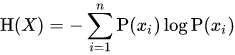

We can extend this idea to a basketball season by dividing the total of the statistic for a given game by the total for the whole season, and then taking the log in the base of the number of games that season.

3. Unique Values: We can divide the number of unique values for a statistic, then divide by the number of games.


These methods have relative advantages and disadvantages. While all will rate a player who performs exactly the same way in every game as the most consistent, they will have different views of who is the most inconsistent player. Entropy will maximize inconsistency for a player who concentrates all performance into a single game. Standard deviation will maximize inconsistency for a player who vacillates between his best and worst performances equally. Uniqueness will maximize inconsistency for a player who never has the same performance twice.

Let's take the following players as examples, looking solely at points:

1. Player A: 82 games, 10 pts every game
2. Player B: 82 games, 30 pts in 1 game and 0 in the other 81
3. Player C: 82 games, with random point totals between 0 and 30
4. Player D: 30 DNPs, 25 games with 0 pts, and 27 games with random point totals between 0 and 30
5. Player E: 82 games, 41 games with 30 pts, 41 games with 0 pts

In [4]:
sample_dict = {
    'Player A': np.repeat(10, 82),
    'Player B': np.append(np.zeros(82), [30]),
    'Player C': np.array(random.choices(range(30), k=82)),
    'Player D': np.append(np.append(np.empty(30), np.zeros(25)), np.array(random.choices(range(30), k=27))),
    'Player E': np.append(np.repeat(30, 41), np.zeros(41))
}
score_dict = {key: {'entropy_score': calculate.measure_vector_entropy(value, base=82),
                    'deviation_score': calculate.measure_vector_deviation(value),
                    'unique_score': calculate.measure_vector_uniqueness(value)
                   } for key, value in list(sample_dict.items())}
score_df = pd.DataFrame(score_dict).transpose()

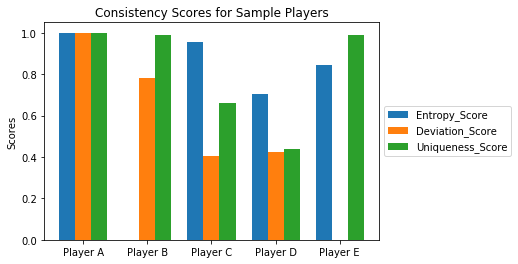

In [5]:
fig, ax = plt.subplots()
width = 0.25
x = np.arange(len(score_df))
p1 = ax.bar(x - width, score_df['entropy_score'], width, label='Entropy_Score')
p2 = ax.bar(x, score_df['deviation_score'], width, label='Deviation_Score')
p3 = ax.bar(x + width, score_df['unique_score'], width, label='Uniqueness_Score')
ax.set_ylabel('Scores')
ax.set_title('Consistency Scores for Sample Players')
ax.set_xticklabels([''] + score_df.index.tolist())
ax.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

The absolute values here matter less than the relative ones. As we can see, ranking from most to least consistent, Deviation ranks A, B, C, D, E; Entropy ranks A, C, E, D, B; and Uniqueness ranks A, B, E, D, C. Which of these feels like the "best" ranking? It's hard to say. The nebulousness of the concept of "consistency" may be one reason why fans and analysts use the term so haphazardly.

For the purpose of this exercise, I will use a combination of variance and entropy to define consistency. I will not use uniqueness, simply because for lower-total statistics where the vast majority of totals will be concentrated in single-digit values (e.g., assists), this statistic will lose a great deal of its descriptive power. Entropy and standard deviation have enough drawbacks used on their own that it might not be wise to use either without the other. Perhaps the most obvious case is for a player who only plays 1 game. Entropy has no choice but to declare this player to have a low-consistency score (all data concentrated in one spot), while standard deviation will give it a high-consistency score whether we count all missed games as 0 (in which case most games are close to the near-0 average) or ignore them (in which case the single game is consistent with itself).

## Selecting and Normalizing Features

basketball-reference.com gives us just about every officially-recorded statistic at the gamelog level. However, we won't necessary want to use all of these statistics in our analysis (or at least not in their rawest forms), for the following reasons:

1. Leakage: Some statistics are directly correlated, like field-goals made and total points. Others are more indirectly related but still obviously correlated, like minutes played with every other statistic.

2. Clarity: We want to emphasize the major counting statistics rather than incidental counting statistics (e.g., personal fouls) or non-counting statistics (e.g., plus/minus)

3. Robustness: Not all statistics have been kept consistently over time. For example, the recording of turnovers, blocks, and steals, as well as the distinction between offensive and defensive rebounds, didn't occur until the mid-1970s. This will make it difficult to use any of them in our analysis. In particular, versions of this model that attempted to incorporate steals and blocks always ended up privileging either the pre-70s or post-70s players, because steals and blocks (likely due to their relatively low raw totals in a given game) are distributed so differently from other statistics that they could not help but bias the results.

4. Spread: We will also need to make sure that the scores are sensibly and comparably distributed. For example, in practice, the absolute entropy score for any player who plays regularly will likely tend to be high, because it is simply not plausible for such a player to score all of their points in a small number of games. Similarly, entropy might not be distributed the same way for, say, points as for assists. If we want scores to have similar weight in differentiating players, we will need them all to have a substantial (and preferably similar) distribution of values. This means we may have to transform the raw values.

5. Historical Accidents: Entropy requires a base, and to normalize scores to a 0-1 range we should use the number of possible games as the base. However, not every season has the same number of games. So we will have to dynamically change the base to align with the total number of games played by each team each season.

For the sake of the exercise, we will analyze only the Big Three statistics of total points, rebounds, and assists.

Let's see how deviation and entropy scores are distributed on a player-season level for those three statistics.

In [6]:
player_df['total_games'] = player_df['year'].apply(lambda x: calculate.get_games_from_year(x))
test_set = player_df.loc[player_df.total_games == 82,:]
ent_distribution = test_set.groupby(['name', 'player_key', 'year'])[[*calculate.norm_factor]] \
    .agg(lambda vec: calculate.measure_vector_entropy(vec, base=82))
std_distribution = test_set.groupby(['name', 'player_key', 'year'])[[*calculate.norm_factor]] \
    .agg(lambda vec: calculate.measure_vector_deviation(vec))

C:\Users\david\Documents\GitHub\public_projects\nba_project\calculate.py:102: RuntimeWarning: invalid value encountered in double_scalars
  std_norm = std/the_max


C:\Users\david\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\david\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


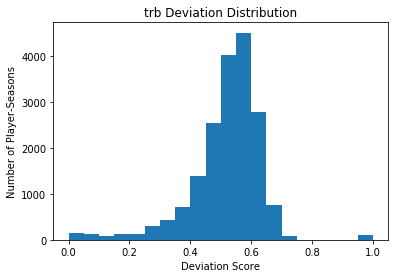

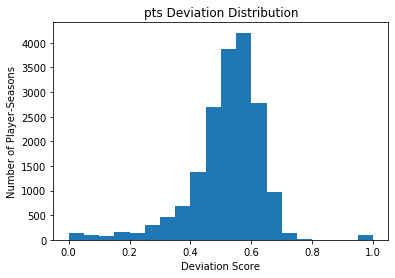

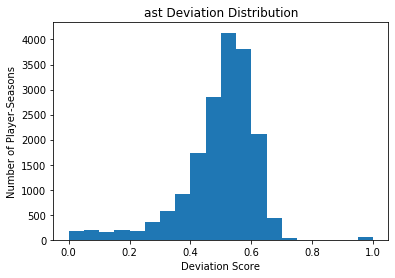

In [7]:
for col in std_distribution.columns:
    plt.hist(std_distribution[col], bins=20)
    plt.title('{feat} Deviation Distribution'.format(feat=col))
    plt.xlabel('Deviation Score')
    plt.ylabel('Number of Player-Seasons')
    plt.show()

It looks like the deviation scores are, by eye, close enough to normal that we can be content with them as is. We needn't worry too much about transforming the data. Now let's look at entropy.

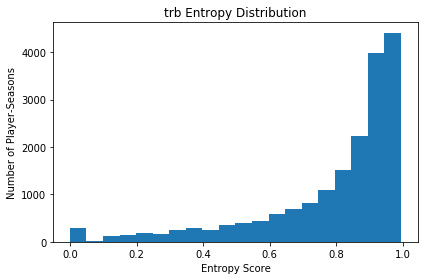

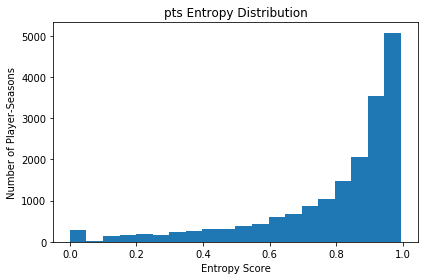

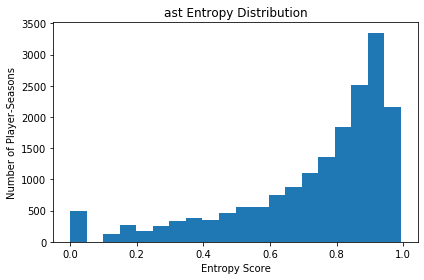

In [8]:
for col in ent_distribution.columns:
    plt.hist(ent_distribution[col], bins=20)
    plt.title('{feat} Entropy Distribution'.format(feat=col))
    plt.xlabel('Entropy Score')
    plt.ylabel('Number of Player-Seasons')
    plt.tight_layout()
    plt.show()

The same is not true of the entropy scores, which is likely due (as mentioned above) to the inherent bias toward high scores. These distributions will not easily normalize. Box-Cox, for example, tends not to improve the situation. As a kind of fudge-factor compromise, the best we can do here is to apply an exponent onto the raw total to force the scores toward essentially the same (non-normal) distribution, where the highest density in the distribution is around 0.8 and the median is around 0.67. This occurs if we apply a power transformation of 3.5 to points, 3 to rebounds, and 2 to assists.

Mod median of trb is 0.6843833588504233


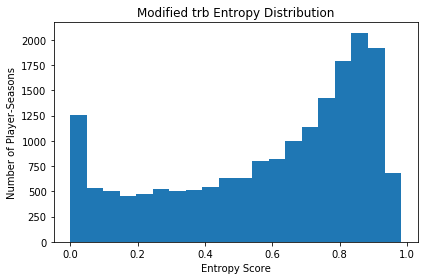

Mod median of pts is 0.6728704206386048


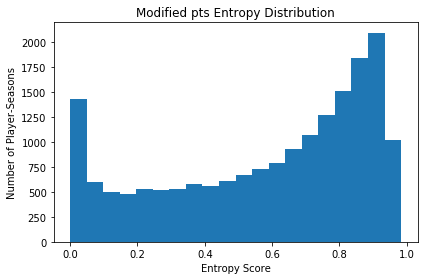

Mod median of ast is 0.6743390343983249


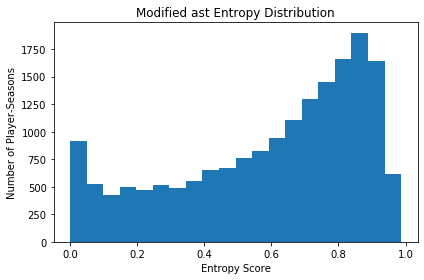

In [9]:
for col in ent_distribution.columns:
    print("Mod median of {col} is {med}".format(col=col, med=np.nanmedian([ent_distribution[col] ** calculate.norm_factor[col]])))
    plt.hist(ent_distribution[col] ** calculate.norm_factor[col], bins=20)
    plt.title('Modified {feat} Entropy Distribution'.format(feat=col))
    plt.xlabel('Entropy Score')
    plt.ylabel('Number of Player-Seasons')
    plt.tight_layout()
    plt.show()

Because entropy scores will still end up higher and more clustered, still, than deviation scores, we will square the final entropy score. This will make the median score somewhat lower than the deviation score, but although the most common scores will cluster a bit higher. This will have the effect of roughly equalizing the impact on the final scores.

## Running the Model

Now, let's run the model and start asking it questions. For example, who had the most consistent season in NBA history?

In [10]:
season_consistency = player_df.groupby(['name', 'player_key', 'year']).agg(calculate.measure_group_consistency, group='player_season').reset_index()
season_consistency['player_year'] = season_consistency['name'] + '_' + season_consistency['year'].astype(str)

C:\Users\david\Documents\GitHub\public_projects\nba_project\calculate.py:89: RuntimeWarning: invalid value encountered in true_divide
  vec_prob = vec_fil/vec_total
C:\Users\david\Documents\GitHub\public_projects\nba_project\calculate.py:31: RuntimeWarning: Mean of empty slice
  results['entropy_score'] = np.nanmean([value for key, value in list(results.items()) if key.startswith('ent_norm_')])**2
C:\Users\david\Documents\GitHub\public_projects\nba_project\calculate.py:32: RuntimeWarning: Mean of empty slice
  results['deviation_score'] = np.nanmean([value for key, value in list(results.items()) if key.startswith('std_')])
C:\Users\david\Documents\GitHub\public_projects\nba_project\calculate.py:33: RuntimeWarning: Mean of empty slice
  results['consistency_score'] = np.nanmean([results['entropy_score'], results['deviation_score']])
C:\Users\david\Documents\GitHub\public_projects\nba_project\calculate.py:100: RuntimeWarning: All-NaN slice encountered
  the_max = np.nanmax(vec)/2
C:\User

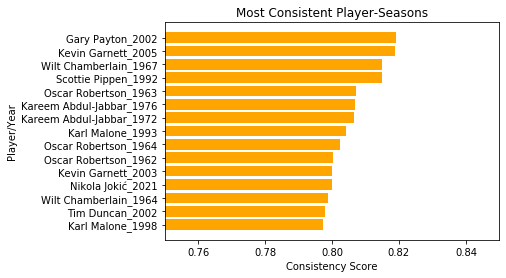

In [11]:
top_15 = season_consistency.sort_values('consistency_score', ascending=False).iloc[:15,:] \
    .sort_values('consistency_score')

plt.barh(top_15['player_year'], top_15['consistency_score'], color='orange')
plt.title('Most Consistent Player-Seasons')
plt.ylabel('Player/Year')
plt.xlabel('Consistency Score')
plt.xlim(0.75, 0.85)
plt.show()

These results make intuitive sense, and the fact that they span the game's history indicates that there doesn't seem to be too much era-based bias in the method. All of the players have reputations as reliable, star-level performers, and the fact that several appear multiple times (Malone, Robertson, and Abdul-Jabbar) shows a degree of meta-consistency. But there are some surprises here. 2002, for example, was a middling year for Gary Payton's Seattle Supersonics, bringing the point guard his usual individual accolades but little attention beyond that. However, he was remarkably reliable that year. He played and started all 82 games; he averaged 22 ppg, never scoring fewer than 11 and only scoring more than 30 5 times; he averaged 9 assists, with only two games below 5 and two above 13; and he averaged just under 5 rebounds, with only 5 games above 7. Who at the time registered that he was having perhaps the most consistent year in NBA history?

Now let's ask another question: who has had the most consistency on a season-to-season basis? In other words, whether or not they were consistent in the individual games of a season, who maintained consistent final season totals over the course of their career? Because we will want to insist that players had lengthy careers as a criterion for consistency, we will use 10 as the entropy base for players who played ten or fewer seasons, or use the player's total number of seasons as the base for those with longer careers.

In [12]:
full_season_consistency = player_df.groupby(['name', 'player_key']).apply(calculate.measure_group_consistency, group='sum_season').reset_index()


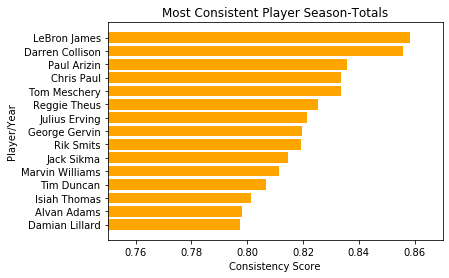

In [13]:
top_15 = full_season_consistency.sort_values('consistency_score', ascending=False).iloc[:15,:] \
    .sort_values('consistency_score')

plt.barh(top_15['name'], top_15['consistency_score'], color='orange')
plt.title('Most Consistent Player Season-Totals')
plt.ylabel('Player/Year')
plt.xlabel('Consistency Score')
plt.xlim(0.75, 0.87)
plt.show()

That Lebron James is the most consistent player in history by this metric is unsurprising, as he has played consistently at a star level for 18 years, but many other players on this list were role players, and in some cases were even considered as disappointments. Take Marvin Williams, famously taken second in the 2005 draft (ahead of Chris Paul) and widely regarded as a bust. Yet he played for 15 years in the league, always recording at least 50 games per year and consistently notching about 800 points, 375 rebounds, and 90 assists.

Last, let's look at game-level consistency across an entire career. Who reliably put up their numbers, game-in and game-out, over the course of a decade or more? For this exercise, we will use as our entropy base the total number of games possible in each season the player was active, with a minimum of 820 (ten normal 82-game seasons).

In [14]:
career_consistency = player_df.groupby(['name', 'player_key']).agg(calculate.measure_group_consistency, group='career').reset_index()

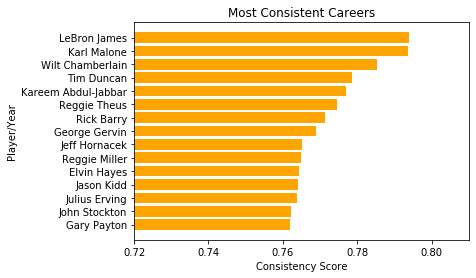

In [15]:
top_15 = career_consistency.sort_values('consistency_score', ascending=False).iloc[:15,:] \
    .sort_values('consistency_score')

plt.barh(top_15['name'], top_15['consistency_score'], color='orange')
plt.title('Most Consistent Careers')
plt.ylabel('Player/Year')
plt.xlabel('Consistency Score')
plt.xlim(0.72, 0.81)
plt.show()

This list also has a few surprising results. The presence of James, Malone, Duncan, and Abdul-Jabbar in the Top 5 is as expected, as these have been the NBA's gold-standard iron men superstars. But Wilt Chamberlain is a surprise at #3, given the three very different phases of his career (the Warriors' record-breaking scorer, the 76ers' triple-double machine, and the Lakers' defensive anchor). His remarkably consistent rebounding score helps him stay high on the leaderboard. Furthermore, 1980s journeyman guard Reggie Theus stands out as an unexpected entry at #6. Though he labored largely unwatched for the pre-Jordan Bulls and in-transition Sacremento Kings, he maintained remarkably consistent averages of around 18 ppg, 6 apg, and 3 rpg for over a decade.

## Conclusion

What does this exercise tell us? Perhaps not much in the way of new insights about the game. But I prefer quantitative precision in language and always want to test vague impressions against data. In many cases this metric confirms what we already thought. But in others, it brings to light unexpected or forgotten achievements. (Alvan Adams, your work has been remembered!) And at the least it can settle bar bets: Hakeem Olajuwon may have been a better player than Patrick Ewing, but at least Ewing was very slightly more consistent!

In [16]:
career_consistency.loc[career_consistency.player_key == 'ewingpa01',:]

,name,player_key,std_trb,ent_raw_trb,ent_norm_trb,std_pts,ent_raw_pts,ent_norm_pts,std_ast,ent_raw_ast,ent_norm_ast,entropy_score,deviation_score,consistency_score
3454,Patrick Ewing,ewingpa01,0.678049,0.966989,0.904201,0.639868,0.965548,0.892309,0.712024,0.925795,0.857097,0.782404,0.676647,0.729525


In [17]:
career_consistency.loc[career_consistency.name == 'Hakeem Olajuwon',:]

,name,player_key,std_trb,ent_raw_trb,ent_norm_trb,std_pts,ent_raw_pts,ent_norm_pts,std_ast,ent_raw_ast,ent_norm_ast,entropy_score,deviation_score,consistency_score
1785,Hakeem Olajuwon,olajuha01,0.651093,0.967739,0.906306,0.657772,0.96628,0.894508,0.680682,0.934049,0.872447,0.794036,0.663182,0.728609
